### <b>실전 프로젝트 - GAN을 이용한 얼굴 마스크 이미지 생성 </b>

* 마스크를 착용한 이미지와 마스크를 착용하지 않은 얼굴 이미지를 생성하는 <b>생성 모델</b>을 만드세요.
* 다음의 두 가지 대표적인 GAN 모델을 실습합니다.
    1. [Generative Adversarial Networks (NIPS 2014)](https://arxiv.org/abs/1406.2661)
    2. [Deep Convolutional Generative Adversarial Networks (ICLR 2016)](https://arxiv.org/abs/1511.06434)
* 또한 자신이 원하는 아키텍처의 GAN 모델을 직접 선택하여 학습하는 실습을 진행합니다.
* 본 프로젝트는 <b>최종적으로 높은 점수(score)를 얻는 것이 목표</b>입니다.
    * <b>Problem</b>이라고 명시된 부분의 소스코드만 작성합니다.
    * <b>알아보기</b>라고 명시된 부분은 단순히 읽고 실행하면 됩니다.
* 최종적으로 <b>팀 단위로 제출할 파일</b>은 다음과 같습니다.
    1. PPT 파일: 사용한 모델과 최종적인 FID 점수에 대한 설명을 포함하기
    2. Colab Notebook 파일: <b>[파일]</b> - <b>[다운로드]</b> - <b>[.ipynb 다운로드]</b>
    3. 최종 결과 이미지(마스크 착용 1,000개 및 마스크 미착용 1,000개)가 포함된 압축 파일
* 자세한 평가 기준은 <b>Problem 1</b>에서 확인하세요.

#### <b>(알아보기) 데이터셋 다운로드</b>

* 실습을 위해 [<b>Face Mask Classification</b> 데이터셋](https://github.com/ndb796/Face-Mask-Classification-20000-Dataset)을 불러옵니다.
* 데이터셋은 흑백(grayscale) 이미지로 구성됩니다.
* GPU 가속기를 이용하기 위해 <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - <b>[GPU]</b>를 선택합니다.
* <b>학습 데이터셋</b>
    * 마스크 착용(with mask): 9,000장
    * 마스크 미착용(wihtout mask): 9,000장
* <b>테스트 데이터셋</b>
    * 마스크 착용(with mask): 1,000장
    * 마스크 미착용(wihtout mask): 1,000장


In [1]:
!git clone https://github.com/ndb796/Face-Mask-Classification-20000-Dataset

fatal: destination path 'Face-Mask-Classification-20000-Dataset' already exists and is not an empty directory.


#### <b>(알아보기) 필요한 라이브러리 불러오기</b>

* 실습을 위한 PyTorch 라이브러리를 불러옵니다.

In [1]:
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

#### <b>(알아보기) 학습 이미지 시각화</b>

* 학습할 이미지 중에서 원하는 이미지를 골라 시각화합니다.

이미지 크기: (224, 224)


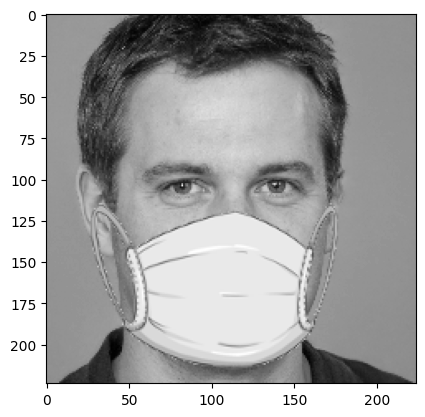

이미지 크기: (224, 224)


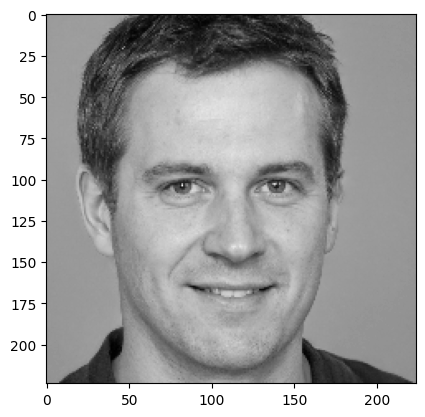

In [2]:
# 마스크를 쓴 이미지 출력
image = Image.open('./Face-Mask-Classification-20000-Dataset/train/with_mask/with-mask-default-mask-seed0030.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

# 마스크를 쓰지 않은 이미지 출력
image = Image.open('./Face-Mask-Classification-20000-Dataset/train/without_mask/seed0030.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

#### <b>(알아보기) 데이터셋 불러오기</b>

* 학습할 이미지 크기: 1 X 64 X 64

In [20]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


#### <b>(알아보기) 기본적인 GAN 실습 - 모델 정의</b>

* 논문 제목: [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) <b>(NIPS 2014)</b>
* 가장 기본적인 GAN 모델을 학습해보는 실습을 진행합니다.
    * 마스크 착용 여부를 선택하기 위해 <b>조건부(conditional) GAN</b>을 이용합니다.
    * <b>Reference</b>: [Conditional Generative Adversarial Nets (2014)](https://arxiv.org/abs/1411.1784)

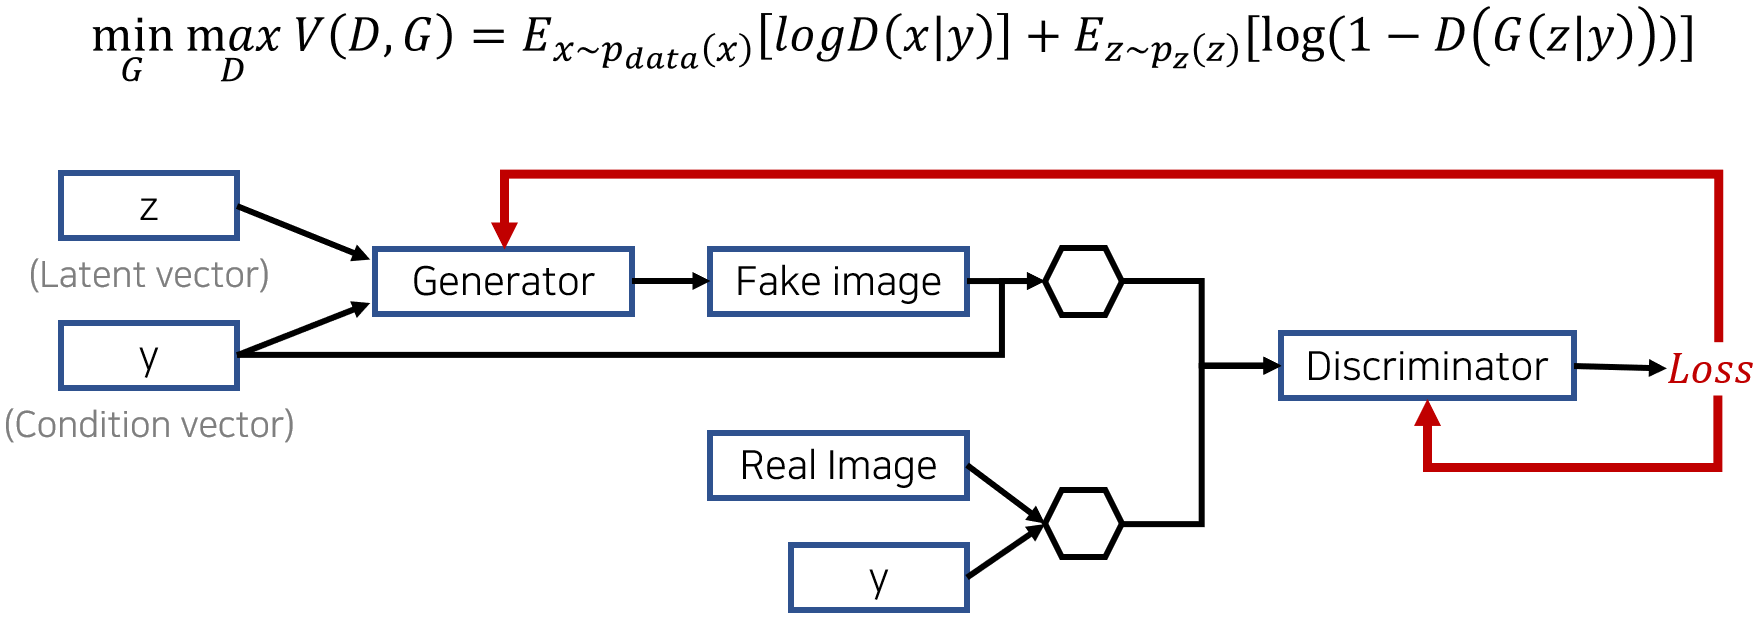

* 생성자(Generator) 및 판별자(Discriminator) 모델을 정의합니다.
    * 생성자 클래스: SimpleGenerator
    * 판별자 클래스: SimpleDiscriminator
* 본 소스코드는 원본 논문에서 제안한 아키텍처와 유사한 아키텍처를 이용합니다.
* <b>Reference</b>: [PyTorch GAN 예시 코드](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py)

In [5]:
latent_dim = 100
n_classes = 2


# 생성자(Generator) 클래스 정의
class SimpleGenerator(nn.Module):
    def __init__(self):
        super(SimpleGenerator, self).__init__()

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, n_classes)

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            *block(1024, 2048),
            nn.Linear(2048, 1 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # 노이즈(noise) 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        inputs = torch.cat((noise, self.label_embed(labels)), -1)
        img = self.model(inputs)
        img = img.view(img.size(0), 1, 64, 64)
        return img


# 판별자(Discriminator) 클래스 정의
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(1 * 64 * 64 + n_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
        flattened = img.view(img.size(0), -1)
        # 이미지 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        inputs = torch.cat((flattened, self.label_embed(labels)), -1)
        output = self.model(inputs)

        return output

#### <b>(알아보기) 기본적인 GAN 실습 - 모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [6]:
# 생성자(generator)와 판별자(discriminator) 초기화
simple_generator = SimpleGenerator()
simple_discriminator = SimpleDiscriminator()

simple_generator.cuda()
simple_discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.MSELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(simple_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(simple_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [7]:
n_epochs = 100 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        # 이미지 생성
        generated_imgs = simple_generator(z, generated_labels)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(simple_discriminator(generated_imgs, generated_labels), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(simple_discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(simple_discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = simple_generator(z, labels)
            save_image(generated_imgs, f"./results/simple/{done}.png", nrow=8, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/100] [D loss: 0.059502] [G loss: 0.717171] [Elapsed time: 20.74s]
[Epoch 1/100] [D loss: 0.173946] [G loss: 0.396223] [Elapsed time: 36.23s]
[Epoch 2/100] [D loss: 0.179396] [G loss: 0.391569] [Elapsed time: 51.31s]
[Epoch 3/100] [D loss: 0.173960] [G loss: 0.573998] [Elapsed time: 66.79s]
[Epoch 4/100] [D loss: 0.141393] [G loss: 0.618841] [Elapsed time: 82.44s]
[Epoch 5/100] [D loss: 0.164274] [G loss: 0.332439] [Elapsed time: 97.96s]
[Epoch 6/100] [D loss: 0.218076] [G loss: 0.595069] [Elapsed time: 113.32s]
[Epoch 7/100] [D loss: 0.133601] [G loss: 0.671565] [Elapsed time: 128.92s]
[Epoch 8/100] [D loss: 0.175354] [G loss: 0.314711] [Elapsed time: 144.53s]
[Epoch 9/100] [D loss: 0.210050] [G loss: 0.428607] [Elapsed time: 160.13s]
[Epoch 10/100] [D loss: 0.196882] [G loss: 0.289268] [Elapsed time: 175.83s]
[Epoch 11/100] [D loss: 0.180767] [G loss: 0.354842] [Elapsed time: 191.43s]
[Epoch 12/100] [D loss: 0.178813] [G loss: 0.397115] [Elapsed time: 207.36s]
[Epoch 13/100] 

* 생성된 이미지 예시를 출력합니다.

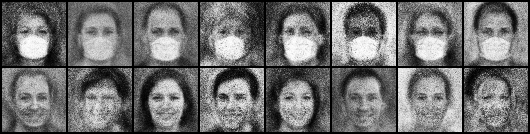

In [8]:
from IPython.display import Image as Display

Display('./results/simple/28000.png')

* 다음의 코드를 이용하여 학습된 모델 파라미터를 저장할 수 있습니다.

In [9]:
# 모델 파라미터 저장
torch.save(simple_generator.state_dict(), "Simple_Generator_for_Face_Mask.pt")
torch.save(simple_discriminator.state_dict(), "Simple_Discriminator_for_Face_Mask.pt")
print("Model saved!")

Model saved!


* 학습된 모델 파라미터를 불러와 이미지 생성을 진행할 수 있습니다.

In [10]:
# 생성자(generator) 초기화
simple_generator = SimpleGenerator()
simple_generator.cuda()
simple_generator.load_state_dict(torch.load("Simple_Generator_for_Face_Mask.pt"))
simple_generator.eval()

SimpleGenerator(
  (label_embed): Embedding(2, 2)
  (model): Sequential(
    (0): Linear(in_features=102, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=2048, bias=True)
    (12): BatchNorm1d(2048, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inpla

* 마스크를 착용한 얼굴을 생성합니다.

In [ ]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(0)

# 이미지 생성
generated_imgs = simple_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/simple/with_mask.png', nrow=10, normalize=True)

Display('./results/simple/with_mask.png')

* 마스크를 착용하지 않은 얼굴을 생성합니다.

In [16]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(1)

# 이미지 생성
generated_imgs = simple_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/simple/with_no_mask.png', nrow=10, normalize=True)

Display('./results/simple/with_no_mask.png')

NameError: name 'simple_generator' is not defined

#### <b>(알아보기) DCGAN 실습 - 모델 정의</b>

* 논문 제목: [Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) <b>(ICLR 2016)</b>
* Convoluational Layer를 활용하여 이미지 생성에 높은 성능을 보이는 DCGAN 모델을 학습해 봅시다.
    * 마스크 착용 여부를 선택하기 위해 <b>조건부(conditional) GAN</b>을 이용합니다.
    * <b>Reference</b>: [Conditional Generative Adversarial Nets (2014)](https://arxiv.org/abs/1411.1784)

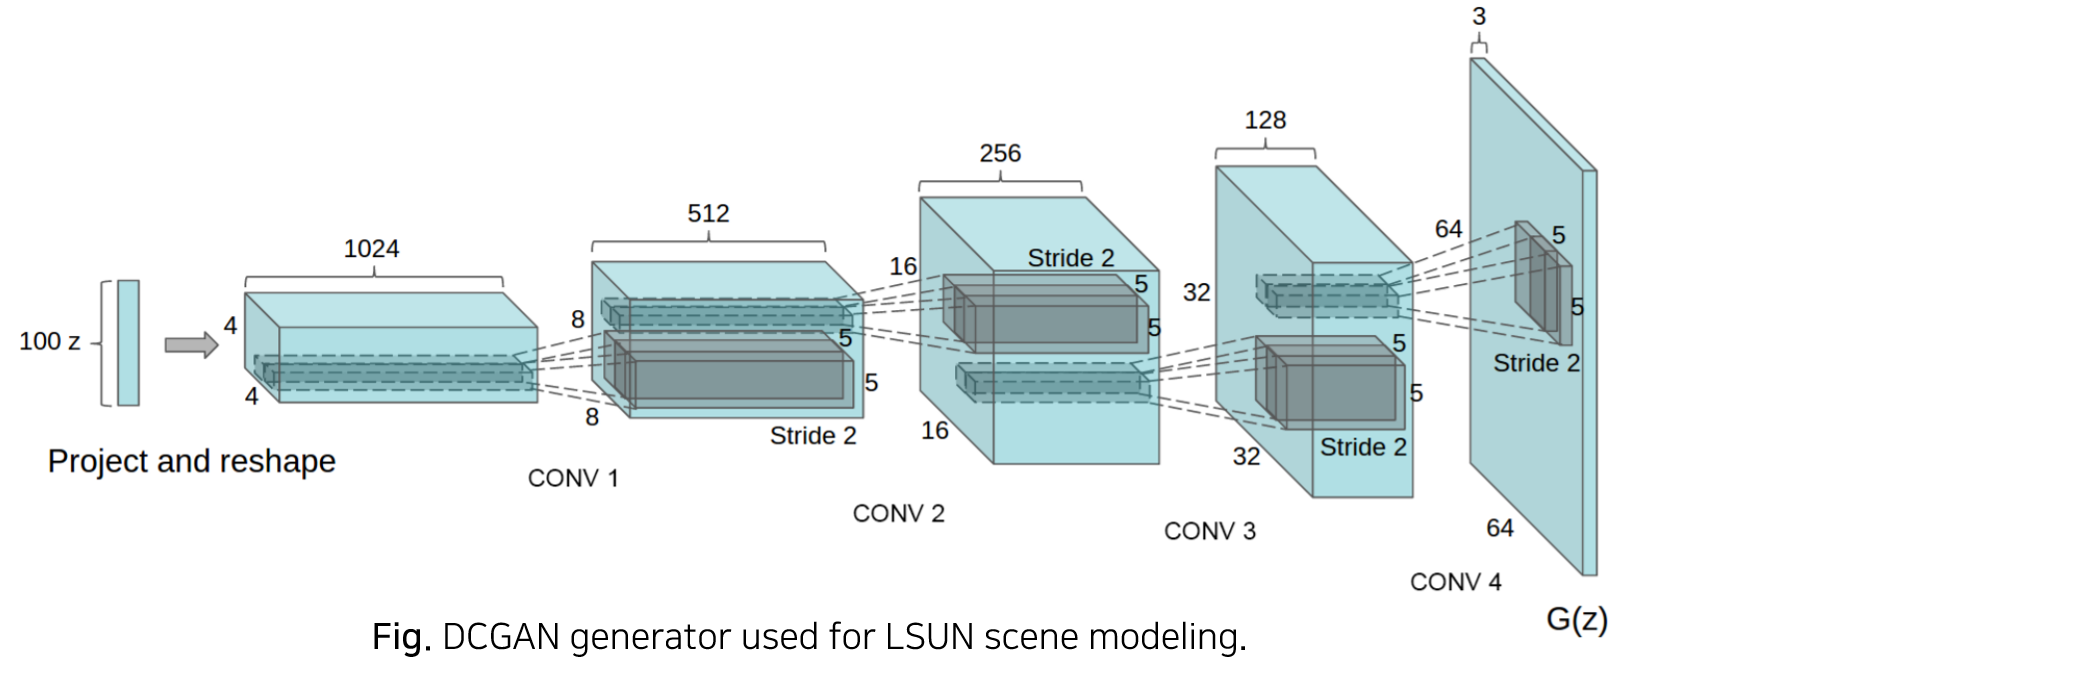

* 생성자(Generator) 및 판별자(Discriminator) 모델을 정의합니다.
    * 생성자 클래스: DCGANGenerator
    * 판별자 클래스: DCGANDiscriminator
* 본 소스코드는 원본 논문에서 제안한 아키텍처와 유사한 아키텍처를 이용합니다.
* <b>Reference</b>: [PyTorch DCGAN 예시 코드](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py)

In [4]:
latent_dim = 100
n_classes = 2


# 생성자(Generator) 클래스 정의
class DCGANGenerator(nn.Module):
    def __init__(self):
        super(DCGANGenerator, self).__init__()

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, n_classes)

        self.init_size = 4 # 원본 크기보다 16배 작은 값으로 초기화
        self.layer1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 512 * self.init_size * self.init_size)) # 초기 채널의 크기는 512 

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512), # 채널의 크기와 동일
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 256으로
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 128로
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 64로
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 3으로
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        # 노이즈(noise) 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        inputs = torch.cat((noise, self.label_embed(labels)), -1)
        output = self.layer1(inputs)
        output = output.view(output.size(0), 512, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output


# 판별자(Discriminator) 클래스 정의
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()

        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        # 너비와 높이가 32배씩 감소
        self.conv_blocks = nn.Sequential(
            *make_block(2, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1),
            nn.Sigmoid()
        )

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, 1 * 64 * 64)

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
        # 이미지 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        embed = self.label_embed(labels).view((img.size(0), 1, 64, 64))
        inputs = torch.cat((img, embed), 1)
        output = self.conv_blocks(inputs)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

#### <b>(알아보기) DCGAN 실습 - 모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [28]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
'''dcgan_generator = DCGANGenerator()
dcgan_discriminator = DCGANDiscriminator()

dcgan_generator.cuda()
dcgan_discriminator.cuda()
'''
# 가중치(weights) 초기화
dcgan_generator.apply(weights_init_normal)
dcgan_discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
adversarial_loss = nn.MSELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0001

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(dcgan_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dcgan_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [79]:
n_epochs = 100 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        # 이미지 생성
        generated_imgs = dcgan_generator(z, generated_labels)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(dcgan_discriminator(generated_imgs, generated_labels), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(dcgan_discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(dcgan_discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = dcgan_generator(z, labels)
            save_image(generated_imgs, f"./results/dcgan/{done}.png", nrow=8, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/100] [D loss: 0.023538] [G loss: 0.886541] [Elapsed time: 21.15s]
[Epoch 1/100] [D loss: 0.008698] [G loss: 0.932131] [Elapsed time: 42.50s]
[Epoch 2/100] [D loss: 0.033031] [G loss: 0.885575] [Elapsed time: 63.76s]
[Epoch 3/100] [D loss: 0.011453] [G loss: 0.892204] [Elapsed time: 84.75s]
[Epoch 4/100] [D loss: 0.019926] [G loss: 0.988333] [Elapsed time: 106.21s]
[Epoch 5/100] [D loss: 0.009762] [G loss: 0.919569] [Elapsed time: 127.68s]
[Epoch 6/100] [D loss: 0.029624] [G loss: 0.983470] [Elapsed time: 149.11s]
[Epoch 7/100] [D loss: 0.078667] [G loss: 0.824978] [Elapsed time: 170.70s]
[Epoch 8/100] [D loss: 0.025616] [G loss: 0.878650] [Elapsed time: 192.14s]
[Epoch 9/100] [D loss: 0.035402] [G loss: 0.838209] [Elapsed time: 213.21s]
[Epoch 10/100] [D loss: 0.008233] [G loss: 0.946052] [Elapsed time: 234.48s]
[Epoch 11/100] [D loss: 0.032093] [G loss: 0.917259] [Elapsed time: 255.39s]
[Epoch 12/100] [D loss: 0.024197] [G loss: 0.856069] [Elapsed time: 276.83s]
[Epoch 13/100

* 생성된 이미지 예시를 출력합니다.

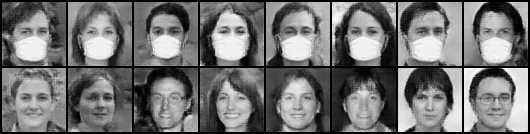

In [17]:
from IPython.display import Image as Display

Display('./results/dcgan/28000.png')

* 다음의 코드를 이용하여 학습된 모델 파라미터를 저장할 수 있습니다.

In [60]:
# 모델 파라미터 저장
torch.save(dcgan_generator.state_dict(), "DCGAN_Generator_for_Face_Mask.pt")
torch.save(dcgan_discriminator.state_dict(), "DCGAN_Discriminator_for_Face_Mask.pt")
print("Model saved!")

Model saved!


* 학습된 모델 파라미터를 불러와 이미지 생성을 진행할 수 있습니다.

In [21]:
# 생성자(generator) 초기화
dcgan_generator = DCGANGenerator()
dcgan_generator.cuda()
dcgan_generator.load_state_dict(torch.load("DCGAN_Generator_for_Face_Mask.pt"))
dcgan_generator.eval()

DCGANGenerator(
  (label_embed): Embedding(2, 2)
  (layer1): Sequential(
    (0): Linear(in_features=102, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Upsample(scale_factor=2.0, mode='nearest')
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_ru

* 마스크를 착용한 얼굴을 생성합니다.

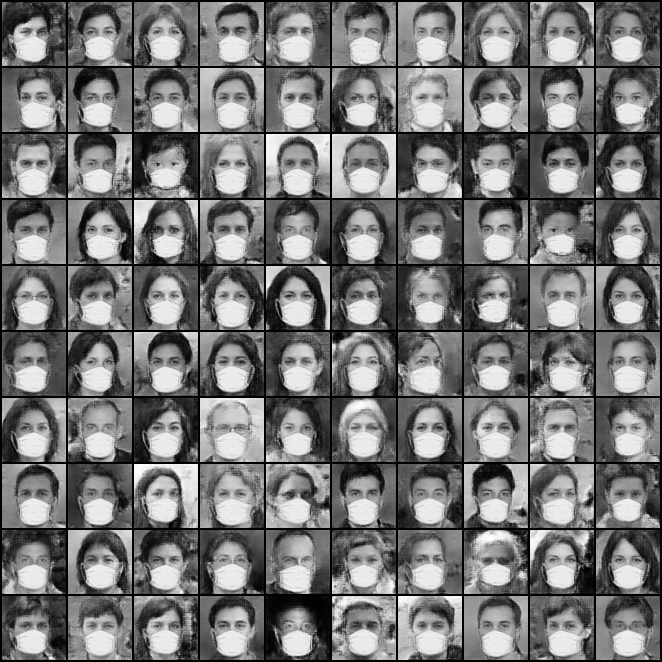

In [8]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(0)

# 이미지 생성
generated_imgs = dcgan_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/dcgan/with_mask.png', nrow=10, normalize=True)

Display('./results/dcgan/with_mask.png')

* 마스크를 착용하지 않은 얼굴을 생성합니다.

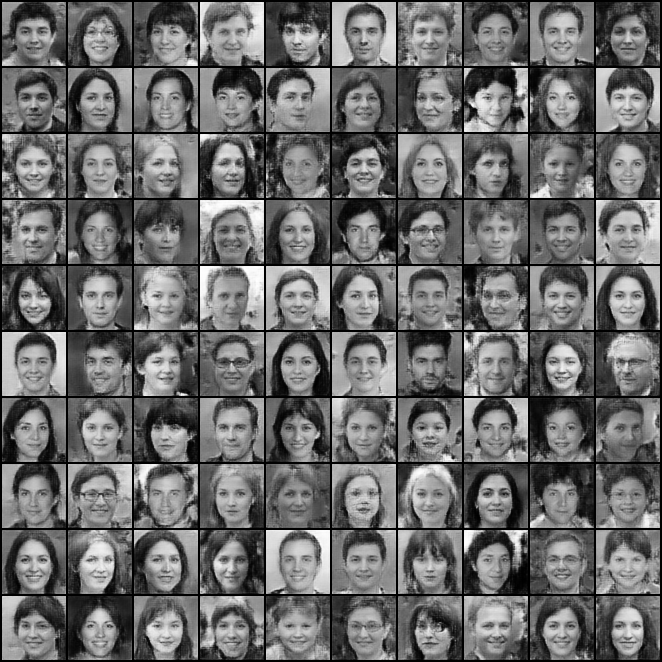

In [17]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(1)

# 이미지 생성
generated_imgs = dcgan_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/dcgan/with_no_mask.png', nrow=10, normalize=True)

Display('./results/dcgan/with_no_mask.png')

#### <b>(알아보기) GAN 모델 평가하기 - FID Score</b>

* 논문 제목: [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567) <b>(CVPR 2016)</b>
* Fréchet Inception Distance(FID) 계산 방법
    * <b>생성된 이미지</b>들과 <b>실제 이미지</b>들을 ImageNet에 넣어 특징(feature)을 추출합니다.
    * 생성된 이미지 특징 분포 G와 실제 이미지 특징 분포 X를 가우시안 분포라고 가정합니다.
    * 두 분포가 얼마나 다른지 계산하기 위해 FID(X, G)를 계산합니다.
* [FID score for PyTorch](https://github.com/hukkelas/pytorch-frechet-inception-distance) 라이브러리를 이용해 간단히 계산할 수 있습니다.
    * 다음과 같이 소스코드를 다운로드할 수 있습니다.

In [22]:
!git clone https://github.com/hukkelas/pytorch-frechet-inception-distance

Cloning into 'pytorch-frechet-inception-distance'...


* <b>Simple GAN</b>: FID 점수를 계산하기 위해 마스크 착용 및 마스크 미착용 이미지를 1,000장씩 생성합니다.

In [ ]:
from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = simple_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/simple/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = simple_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/simple/without_mask/{i * 100 + j}.png', normalize=True)

NameError: name 'simple_generator' is not defined

* <b>DCGAN</b>: FID 점수를 계산하기 위해 마스크 착용 및 마스크 미착용 이미지를 1,000장씩 생성합니다.

In [80]:
from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = dcgan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/dcgan/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = dcgan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/dcgan/without_mask/{i * 100 + j}.png', normalize=True)

* 다음과 같이 <b>FID를 계산</b>할 수 있습니다.
    * <b>FID 값이 낮을수록 우수한 모델</b>입니다.
* 메모리 초과 오류(CUDA error: out of memory)가 발생할 수 있습니다.
    * 메모리 초과가 발생할 때는 학습했던 GAN 네트워크를 잘 저장한 뒤에 <b>[런타임]</b> - <b>[런타임 다시 시작]</b>을 진행합니다.
* Simple GAN의 마스크 미착용 FID 점수: 247.69
* Simple GAN의 마스크 착용 FID 점수: 320.88
* DCGAN의 마스크 미착용 FID 점수: 171.67
* DCGAN의 마스크 착용 FID 점수: 114.97

In [12]:
import cv2

In [15]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/simple/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

Looking for images in ./results/simple/without_mask\*.png
Looking for images in ./results/simple/without_mask\*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask\*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask\*.jpg
257.80512428509564


c:\Users\gka06\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gka06\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/simple/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/simple/with_mask\*.png
Looking for images in ./results/simple/with_mask\*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.jpg
317.84484712346153


c:\Users\gka06\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gka06\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [82]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

In [81]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/dcgan/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

Looking for images in ./results/dcgan/with_mask\*.png
Looking for images in ./results/dcgan/with_mask\*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.jpg
109.035102888739


c:\Users\gka06\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gka06\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### <b>Problem 1. 나만의 모델을 만들어 학습 및 평가하기</b>

* 나만의 GAN 모델을 이용해 <b>최대한 높은 FID 점수</b>를 받아보세요.
    * (Hint) 200 epochs 이상으로 학습해보기
    * (Hint) DCGAN의 아키텍처를 효율적으로 바꿔보기
    * (Hint) WGAN 등 [다른 아키텍처들을](https://github.com/eriklindernoren/PyTorch-GAN) 적용해보기
    * (Hint) 사전 학습된(pre-trained) GAN 모델 사용해보기
* 결과적으로 자신이 학습한 모델의 <b>최종 FID 점수(score)를 작성</b>하세요.
    * 마스크 착용 및 미착용 이미지를 <b>각각 1,000장씩 생성</b>하여 FID를 계산합니다.
    * 마스크 착용: {답을 쓰세요.}
    * 마스크 미착용: {답을 쓰세요.}
* 결과 이미지의 해상도는 1 X 64 X 64가 되어야 합니다.

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

# data (img)
img_height = 64
img_width = 64
channels = 3

In [73]:
train_dataset[1].

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

In [ ]:
# 생성자(Generator) 클래스 정의
class CustomGenerator(nn.Module):
    def __init__(self):
        super(CustomGenerator, self).__init__()
        # 적절한 소스코드를 작성하세요.
        self.block=nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)

    def forward(self, noise, labels):
        # 적절한 소스코드를 작성하세요.
        pass


# 판별자(Discriminator) 클래스 정의
class CustomDiscriminator(nn.Module):
    def __init__(self):
        super(CustomDiscriminator, self).__init__()
        # 적절한 소스코드를 작성하세요.
        pass

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
        # 적절한 소스코드를 작성하세요.
        pass

In [ ]:
# 모델 학습하는 코드 작성하기
pass

In [ ]:
# 평가 수행
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/custom/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

In [ ]:
# 평가 수행
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/custom/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

In [ ]:
# ./results/custom/ 폴더의 모든 파일을 results.zip라는 이름으로 압축
!zip ./results.zip -r ./results/custom/*

In [ ]:
# Google Colab으로부터 results.zip 압축 파일 다운로드
from google.colab import files

files.download('./results.zip')

* PPT에 들어갈 내용
    1. 최종적으로 얻은 점수 (마스크 미착용 FID 점수 + 마스크 착용 FID 점수)
    2. 좋은 결과를 만들기 위해 어떤 전략을 사용했는지, 그 이유는 무엇인지
    3. 소스코드에서 핵심이 되는 부분 캡처 사진 및 설명
    4. 자신의 GAN에서 생성된 이미지들 캡처 사진
* 점수 판정 기준
    * <b>FID의 점수 합이 가장 작은 팀</b>이 1등입니다.
    * 마스크 미착용 FID 점수 = 171.67이고, 마스크 착용 FID 점수 = 114.97이라면?
    * 최종 점수 = 171.67 + 114.97 = 286.64
* 최종적으로 <b>팀 단위로 제출할 파일</b>은 다음과 같습니다.
    1. PPT 파일: 사용한 모델과 최종적인 FID 점수에 대한 설명을 포함하기
    2. Colab Notebook 파일: <b>[파일]</b> - <b>[다운로드]</b> - <b>[.ipynb 다운로드]</b>
    3. 최종 결과 이미지(마스크 착용 1,000개 및 마스크 미착용 1,000개)가 포함된 압축 파일
* 최종 결과 이미지는 다음과 같은 양식으로 압축 파일(.zip) 형태로 제출합니다.
    * with_mask와 without_mask 이미지들이 서로 다른 폴더로 확실히 구분되어야 합니다.
    * <b>PPT에 기록된 FID 점수와 동일한 점수</b>가 나오는 이미지여야 합니다.

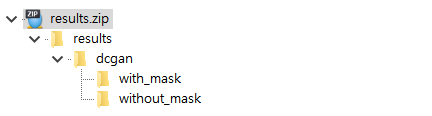

* GAN은 학습이 어려운 네트워크 중 하나입니다.
    * 학습 자체가 안 되는 문제가 발생할 수 있습니다. (처음부터 D loss: 0.5, G loss: 1.0 고정되는 문제)
    * 같은 레이블에 대하여 거의 똑같은 이미지만 생성될 수 있습니다. (mode collapse)
* (Hint) 학습이 잘 안 되는 경우 배치 사이즈, learning rate, 아키텍처를 다시 확인하고 조절합니다.
* FID 점수는 이미지 생성을 할 때마다 변경될 수 있습니다.
    * 실제로 해당 FID 점수가 나왔는지 확인할 필요가 있으므로, 생성된 이미지 파일(총 2,000장)을 꼭 함께 제출합니다.